In [1]:
# Basic python packages
import os
from os import listdir
from os.path import isfile, join
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from collections import defaultdict
import glob

# General machine learning packages
from sklearn.model_selection import train_test_split

# Packages related to images
from PIL import Image
import PIL

# Packages for neural networks
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from keras.layers import Dense, Dropout, Conv2D, MaxPool2D, Flatten, Embedding
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
# Check if GPU works
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [46]:
#Paths to different folders/files
image_dir = "../train_set/train_set"
test_image_dir = "../real_test_data"
labels_file = "../train_labels.csv"
training_path = '../training_data/'
validation_path = '../validation_data/'

img_size = (200, 200) #Size of the input of the neural networks
IMG_SHAPE = img_size + (3,)
batch_size = 32
n_labels = 80

In [47]:
labels = pd.read_csv(labels_file)
labels

,img_name,label
0,train_1.jpg,21
1,train_2.jpg,29
2,train_3.jpg,17
3,train_4.jpg,21
4,train_5.jpg,50
...,...,...
30607,train_30608.jpg,53
30608,train_30609.jpg,18
30609,train_30610.jpg,6
30610,train_30611.jpg,21


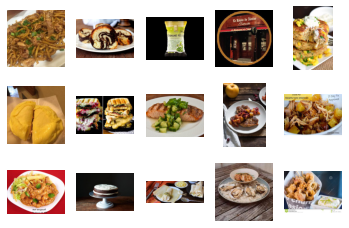

In [48]:
def plot_random_images(img_names, n_x=2, n_y=2, seed=0):
    """
    Plots random images from de data set in a n_x by n_y grid

    :image_names: List with the names of all images
    :n_x: Height of the grid
    :n_x: Width of the grid
    :seed: Seed for the random sample
    :return: nothing
    """ 
    f, axs = plt.subplots(n_x, n_y)
    sample = img_names.sample(n_x * n_y, random_state=seed)
    c = 0
    for x in range(n_x):
        for y in range(n_y):
            img = plt.imread(image_dir + "/" + sample.iloc[c])
            axs[x, y].imshow(img)
            axs[x, y].axis('off')
            c += 1

plot_random_images(labels["img_name"], 3, 5)

# Image size
Most machine learning requires that the input is always of the same size. Because our images are not always of the same size. We have to resize them

In [49]:
def resize_images(img_names, img_dir, new_img_dir):
    #Deprecated, replaced by the flow from directory
    for img in img_names:
        Image.open(img_dir + "/" + img).resize(img_size).save(new_img_dir + "/" + img)

# resize_images(labels["img_name"], image_dir, resized_train_dir)

# Split
To test our models locally, we must split our data into a train and test set


In [50]:
# X_train, X_test, y_train, y_test = train_test_split(labels["img_name"].to_numpy(), labels["label"].to_numpy(), test_size=0.2, random_state=42)
# y_train

# Reformat data for learning
To be able to load the data with a generator. We must split the training and validation data and place them into a folder based on their label.

In [51]:
def generate_label_folders(image_path, image_names, image_labels, destination_path):
    """
    Splits a single folder with images into multiple folders where images are placed based on their labels.

    :image_path: path to the folder with the images
    :image_names: A numpy array with the names of all images
    :image_labels: A numpy array with the labels of all images
    :destination_path: Path of the folder where the images are placed into
    :return: Nothing
    """ 
    for i in range(len(image_names)):
        # Check if the directory exists. Else, make one
        isExist = os.path.exists(destination_path + str(image_labels[i]))
        if not isExist:
            os.makedirs(destination_path + str(image_labels[i]))
            
        # Copy the image
        img = Image.open(image_path + "/" + image_names[i])
        img.save(destination_path + "/" + str(image_labels[i]) + "/" + image_names[i])
        

# generate_label_folders(image_dir, X_train, y_train, training_path)
# generate_label_folders(image_dir, X_test, y_test, validation_path)

# Image Loading
Because the dataset is so large, we cant just load it into our memory. Instead we generate batches of images. These images are then altered a little bit to create higher variance between images and artificially increase the size of our training data.

In [52]:
def normalize(image):
    image = tf.cast(image, tf.float32)
    image = (image / 127.5) - 1
    return image

train_datagen = ImageDataGenerator(
        preprocessing_function=normalize,
        shear_range=2,
        zoom_range=0.2,
        rotation_range = 2,
        horizontal_flip=True)

test_datagen = ImageDataGenerator(
        preprocessing_function=normalize)

train_generator = train_datagen.flow_from_directory(
        training_path,
        target_size=img_size,
        batch_size=batch_size,
        class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
        validation_path,
        target_size=img_size,
        batch_size=batch_size,
        shuffle=True,
        class_mode='categorical')

test_generator = test_datagen.flow_from_directory(
        test_image_dir,
        target_size=img_size,
        batch_size=batch_size,
        shuffle=False,
        class_mode='categorical')

Found 24489 images belonging to 80 classes.
Found 6123 images belonging to 80 classes.
Found 7653 images belonging to 7653 classes.


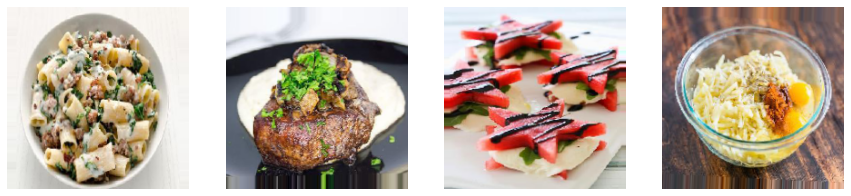

In [10]:
fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(15,15))

for i in range(4):

    # convert to unsigned integers for plotting
    image = next(train_generator)[0][0]
    # changing size from (1, 200, 200, 3) to (200, 200, 3) for plotting the image
    image = np.squeeze(image) * 0.5 + 0.5
    # plot raw pixel data
    ax[i].imshow(image)
    ax[i].axis('off')

In [11]:
def train_model(model, steps_per_epoch=150, epochs=3, validation_steps=20, workers=7, checkpoint_loc=""):
    """
    Trains a given model

    :steps_per_epoch: Amount of batches uploaded per epoch. Cant be higher than +- 200
    :epochs: Amount of times the model trains on the data
    :validation_steps: Amount of batches used for validation. Cant be higher than +- 50
    :workers: Amount of processes used to load the data
    :checkpoint_loc: Place for the model checkpoints to be saved
    :return: The trained model and some training data
    """ 
    # Create a callback that saves the model's weights
    cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_loc,
                                                     save_weights_only=True,
                                                     verbose=1)
    begin_time = datetime.datetime.now()
    history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=epochs, validation_data=validation_generator, validation_steps=validation_steps, workers=workers, callbacks=[cp_callback])
    print(datetime.datetime.now() - begin_time)
    return (model, history)

In [12]:
def plot_history(history):
    #Plots the training data.
    plt.plot(history.history['accuracy'], label='accuracy')
    plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    plt.show()

# Example: simple pre-trained CNN

In [13]:
def make_MNV2model(n_labels):
    base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                                   include_top=False,
                                                   weights='imagenet')
    base_model.trainable = False


    global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
    prediction_layer = tf.keras.layers.Dense(n_labels)

    MNV2model = tf.keras.Sequential([
      base_model,
      global_average_layer,
      prediction_layer
    ])

    base_learning_rate = 0.0001
    MNV2model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate),
                  loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])
#     ckpt = tf.train.Checkpoint(step=tf.Variable(1), optimizer=opt, net=net, iterator=iterator)
# manager = tf.train.CheckpointManager(ckpt, './tf_ckpts', max_to_keep=3)
    return MNV2model

MNV2model = make_MNV2model(n_labels)
MNV2model.load_weights("../Model_weights/MNV2/")

# MNV2model.summary()

In [14]:
MNV2model, history_MNV2 = train_model(MNV2model, steps_per_epoch=1, epochs=1, checkpoint_loc="../Model_weights/MNV2/")

1/1 [==============================] - ETA: 0s - loss: 1.3773 - accuracy: 0.7031
Epoch 00001: saving model to ../Model_weights/MNV2\
1/1 [==============================] - 16s 16s/step - loss: 1.3773 - accuracy: 0.7031 - val_loss: 2.0982 - val_accuracy: 0.4930
0:00:17.358644


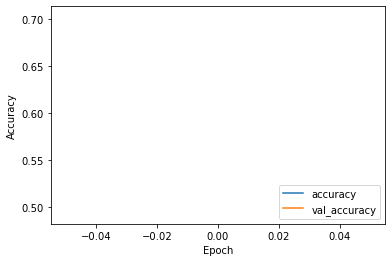

In [15]:
plot_history(history_MNV2)

# More models:

# Predict the test set
We also have to predict the real test set and save the results to upload to kaggle

In [74]:
def predict_test(model):
    preds = MNV2model.predict(test_generator)
    preds_cls_idx = preds.argmax(axis=-1)
    idx_to_cls = {v: k for k, v in train_generator.class_indices.items()}
    preds_cls = np.vectorize(idx_to_cls.get)(preds_cls_idx)
    filenames_to_cls = list(zip(test_generator.filenames, preds_cls))
    
    l = []
    n = []
    for p in filenames_to_cls:
        n.append(p[0].split("\\")[-1])
        l.append(p[1])
    return pd.DataFrame(list(zip(n, l)), columns=['img_name','label'])

res = predict_test(MNV2model)
res.to_csv("sample_submission2.csv", index=False)